In [1]:
import imp
import os
import logging

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import statsmodels

from BuildingControlsSimulator.Simulator.Simulator import Simulator
from BuildingControlsSimulator.Simulator.Config import Config
from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.ControllerModels.Deadband import Deadband
from BuildingControlsSimulator.DataClients.LocalDestination import LocalDestination
from BuildingControlsSimulator.DataClients.DataSpec import DonateYourDataSpec
from BuildingControlsSimulator.DataClients.DataClient import DataClient
from BuildingControlsSimulator.DataClients.GCSDYDSource import GCSDYDSource
from BuildingControlsSimulator.OutputAnalysis.OutputAnalysis import OutputAnalysis
from BuildingControlsSimulator.StateEstimatorModels.LowPassFilter import LowPassFilter

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2


In [2]:
dyd = DataClient(
    source=GCSDYDSource(
        gcp_project=os.environ.get("DYD_GOOGLE_CLOUD_PROJECT"),
        gcs_uri_base=os.environ.get("DYD_GCS_URI_BASE"),
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        meta_gcs_uri=os.environ.get("DYD_METADATA_URI"),
    ),
    destination=LocalDestination(
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        data_spec=DonateYourDataSpec(),
    ),
    nrel_dev_api_key=os.environ.get("NREL_DEV_API_KEY"),
    nrel_dev_email=os.environ.get("NREL_DEV_EMAIL"),
    archive_tmy3_meta=os.environ.get("ARCHIVE_TMY3_META"),
    archive_tmy3_data_dir=os.environ.get("ARCHIVE_TMY3_DATA_DIR"),
    ep_tmy3_cache_dir=os.environ.get("EP_TMY3_CACHE_DIR"),
    simulation_epw_dir=os.environ.get("SIMULATION_EPW_DIR"),
)

In [3]:
meta = dyd.source.get_metadata()

In [4]:
sim_ids = meta[
    (meta["Model"] == "ecobee4") 
    & (meta["City"] == "Phoenix")
    & (meta["Style"] == "detached")
    & (meta["installedCoolStages"] == 1)
    & (meta["Has a Heat Pump"] == False)
    & (meta["Number of Remote Sensors"] == 1)
    & (meta["Number of Floors"] == 1)
].sample(n=1, replace=False, random_state=2336).Identifier.to_list()

In [5]:
sim_ids

['2756663bc57afe940c552ab1080f2ec09ef54e24']

In [6]:
sim_config = Config.make_sim_config(
    identifier=sim_ids,
    latitude=33.481136,
    longitude=-112.078232,
    start_utc="2018-07-05",
    end_utc="2018-07-10",
    min_sim_period="3D",
    step_size_minutes=5,
)

In [7]:
%%time
master = Simulator(
    data_client=dyd,
    sim_config=sim_config,
    building_models=[
        EnergyPlusBuildingModel(
            idf=IDFPreprocessor(idf_file="AZ_Phoenix_gasfurnace_crawlspace_IECC_2018_cycles.idf",),
        )
    ],
    state_estimator_models=[
        LowPassFilter(alpha_temperature=0.3, alpha_humidity=0.3)
    ],
    controller_models=[Deadband(deadband=1.0),],
)


CPU times: user 2.63 s, sys: 18.3 ms, total: 2.65 s
Wall time: 2.65 s


In [8]:
%%time
# simulate
master.simulate(local=True, preprocess_check=True)

/home/bcs/.local/share/virtualenvs/building-controls-simulator-_QCXB2qn/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1342: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized

/home/bcs/.local/share/virtualenvs/building-controls-simulator-_QCXB2qn/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



CPU times: user 14.9 s, sys: 1.05 s, total: 16 s
Wall time: 54.6 s


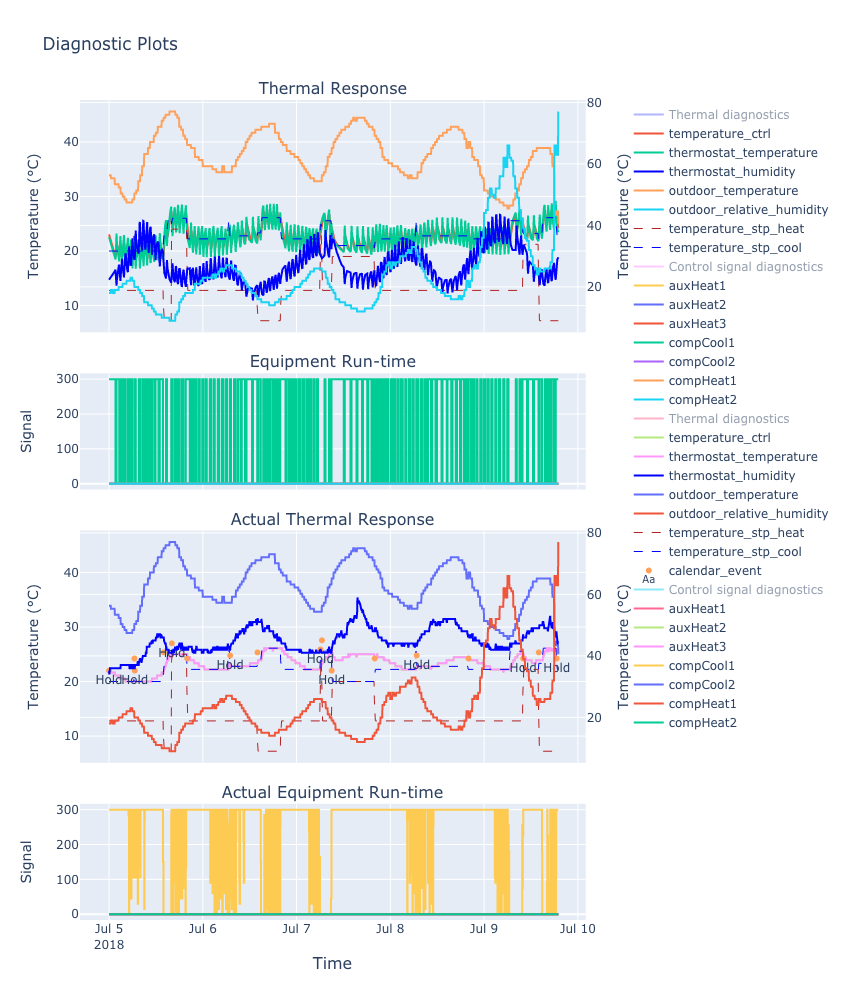

In [9]:
sim_analysis = OutputAnalysis(output_df=master.simulations[0].output, input_df=master.simulations[0].full_input, data_spec=dyd.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=True)